In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [14]:
np.random.seed(11)

In [15]:
k = 10
N = 100
ws = []
for i in range(N):
    ws.append(np.random.multivariate_normal(np.zeros(k), np.eye(k), 1))
W = np.vstack(ws)

In [16]:
F = np.random.rand(k, k)
X = np.matmul(F, W.T).T

In [17]:
Xtrain = X[:80, :]
Xtest = X[80:, :]

In [104]:
R = cp.Variable((k, k))
eta = cp.Variable(k)

In [105]:
obj = 0.

for i in range(80):
    x = Xtrain[i, :].T
    obj += cp.quad_form(x, R) - 2*cp.matmul(x.T, eta) + cp.matrix_frac(eta, R) - cp.log_det(R)

In [106]:
prob = cp.Problem(cp.Minimize(obj), [R >= 0, R == R.T])
prob.solve()
Fopt = R.value

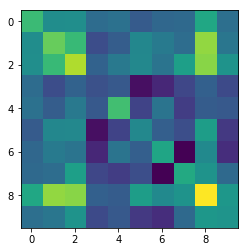

In [108]:
plt.imshow(np.matmul(F, F.T))

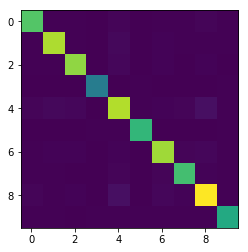

In [110]:
plt.imshow(np.linalg.inv(Fopt))

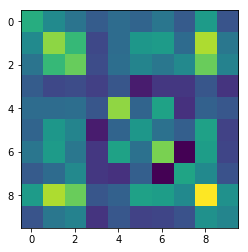

In [20]:
Favg = 1/80. * np.sum(np.array([np.outer(X[i, :], X[i, :]) for i in range(80)]), axis=0)
plt.imshow(Favg)

In [49]:
np.array([1, 2, 3]).shape

(3,)

In [36]:
import scipy as sp
import scipy.stats
import math

# Compute log likelihood of test set
def test_likelihood(mean, covariance):
    l = 0
    for i in range(20):
        x = X[80+i, :]
        l += -(1/2.)*np.matmul((x - mean).T, np.matmul(np.linalg.inv(covariance), (x - mean)))
        l += -(1/2.)*(k * np.log(2*math.pi) + np.log(np.linalg.det(covariance)))
    return l

In [127]:
print(f"Tru log likelihood: {test_likelihood(np.zeros(10), np.matmul(F, F.T))}")
print(f"Opt log likelihood: {test_likelihood(np.zeros(10), np.linalg.inv(R.value))}")
print(f"Avg log likelihood: {test_likelihood(np.zeros(10), Favg)}")
print(f"Per log likelihood: {test_likelihood(np.zeros(10), Favg + np.random.uniform()*np.eye(10))}")

Tru log likelihood: -183.29370784874172
Opt log likelihood: -427.22667420371863
Avg log likelihood: -190.49084676401293
Per log likelihood: -269.6006925972442


In [91]:
def estimate(x, K, Sigma, mean=np.zeros(k)):
    xhat = cp.Variable(k)
    constraints = [x[i] == xhat[i] for i in K]
    R = np.linalg.inv(Sigma)
    obj = cp.quad_form(xhat - mean, R)
    p = cp.Problem(cp.Minimize(obj), constraints)
    p.solve()
    return xhat.value

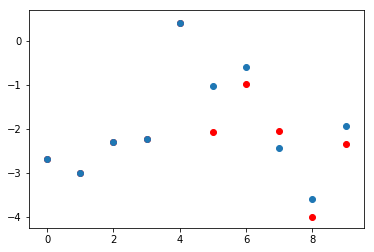

In [115]:
plt.scatter(np.arange(k), xtest, c='r')
plt.scatter(np.arange(k), estimate(xhat, [0, 1, 2, 3, 4,], Favg))

In [92]:
xtest = X[80, :]
xtest

array([-2.67723399, -2.9955666 , -2.29670168, -2.23334956,  0.4016882 ,
       -2.08111469, -0.9769002 , -2.04809829, -4.01253746, -2.34926633])

In [93]:
xhat = estimate(xtest, np.arange(9), Favg, mean=np.ones(k))

In [129]:
def errsfor(xtest, Fest):
    errs = np.zeros(k)
    for i in range(k):
        K = set(np.arange(10))
        K.remove(i)
        xhat = estimate(xtest, K, Fest)
        errs[i] = xtest[i] - xhat[i]
    for i in range(10):
        errs[i] /= Fest[i, i]
    return errs

(0, 1)

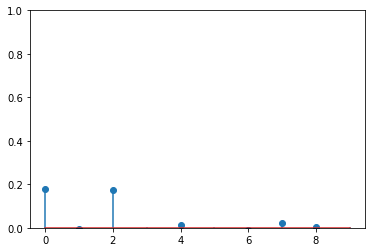

In [100]:
plt.stem(errsfor(Favg))
plt.ylim(0, 1)

(0, 1)

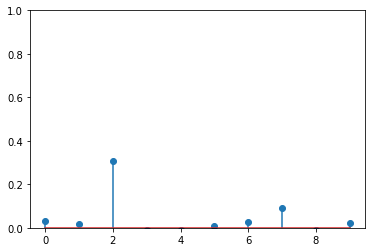

In [101]:
plt.stem(errsfor(np.matmul(F, F.T)))
plt.ylim(0, 1)

In [130]:
def valid(Fest):
    avg = 0.
    for i in range(20):
        x = X[80+i, :]
        avg += np.sum(np.abs(errsfor(x, Fest)))
    avg /= 20
    return avg

In [131]:
valid(Favg)

0.33452205040389404

In [132]:
valid(np.matmul(F, F.T))

0.29269882583567186

In [133]:
valid(Favg + np.random.uniform()*np.eye(10))

1.3564599112736848

In [135]:
valids = [valid(Favg + eps*np.eye(10)) for eps in np.logspace(0, 10, 5)]

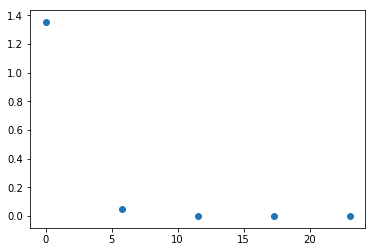

In [139]:
plt.scatter(np.log(np.logspace(0, 10, 5)), valids)

In [138]:
for eps in np.logspace(0, 10, 5):
    print(eps)

1.0
316.22776601683796
100000.0
31622776.60168379
10000000000.0
